In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions =  ['hello', 'great', 'meet', 'nicetosee']

data = np.concatenate([
    np.load('datasetTFSL03/seq_right_hello_1696854556.npy'),
    np.load('datasetTFSL03/seq_right_great_1696854556.npy'),
    np.load('datasetTFSL03/seq_right_meet_1696854556.npy'),
    np.load('datasetTFSL03/seq_right_nicetosee_1696854556.npy'),
], axis=0)

data.shape

(7068, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(7068, 30, 99)
(7068,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(7068, 4)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6361, 30, 99) (6361, 4)
(707, 30, 99) (707, 4)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44196 (172.64 KB)
Trainable params: 44196 (172.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=120,
    callbacks=[
        ModelCheckpoint('models/model_tfslDuo03.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/120
197/199 [============================>.] - ETA: 0s - loss: 72.8123 - acc: 0.4967
Epoch 1: val_acc improved from -inf to 0.72984, saving model to models\model_tfslDuo03.h5
199/199 [==============================] - 6s 22ms/step - loss: 72.4762 - acc: 0.4994 - val_loss: 31.2106 - val_acc: 0.7298 - lr: 0.0010
Epoch 2/120
  1/199 [..............................] - ETA: 3s - loss: 75.3662 - acc: 0.6250

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/199 [============================>.] - ETA: 0s - loss: 13.6507 - acc: 0.8015
Epoch 2: val_acc improved from 0.72984 to 0.80764, saving model to models\model_tfslDuo03.h5
199/199 [==============================] - 4s 21ms/step - loss: 13.6241 - acc: 0.8008 - val_loss: 5.3779 - val_acc: 0.8076 - lr: 0.0010
Epoch 3/120
198/199 [============================>.] - ETA: 0s - loss: 27.3130 - acc: 0.8494
Epoch 3: val_acc did not improve from 0.80764
199/199 [==============================] - 4s 19ms/step - loss: 28.3735 - acc: 0.8475 - val_loss: 712.3658 - val_acc: 0.2772 - lr: 0.0010
Epoch 4/120
199/199 [==============================] - ETA: 0s - loss: 817.8012 - acc: 0.3058
Epoch 4: val_acc did not improve from 0.80764
199/199 [==============================] - 4s 19ms/step - loss: 817.8012 - acc: 0.3058 - val_loss: 277.4008 - val_acc: 0.3126 - lr: 0.0010
Epoch 5/120
198/199 [============================>.] - ETA: 0s - loss: 145.2214 - acc: 0.3324
Epoch 5: val_acc did not improve from 0.

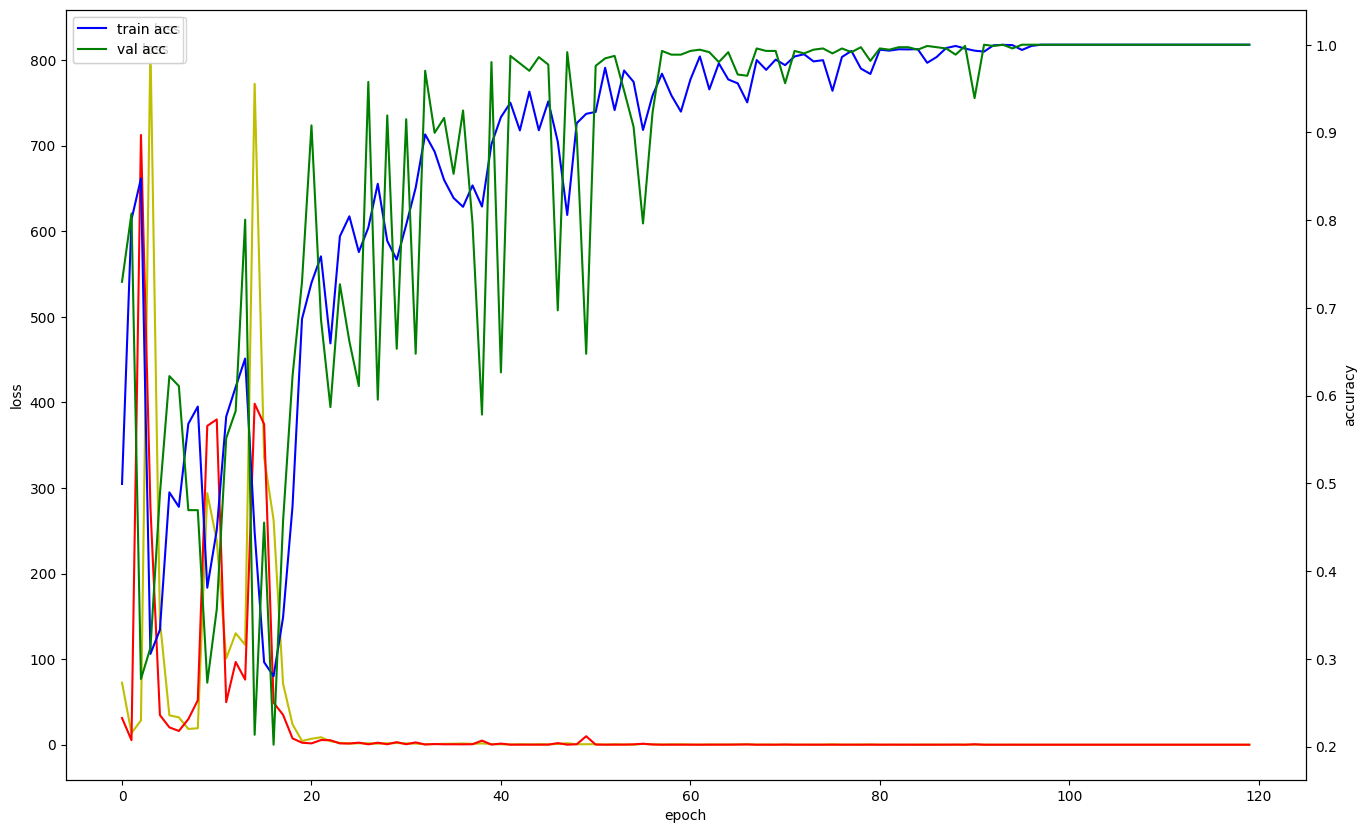

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model_right.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

OSError: No file or directory found at models/model_right.h5